In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the LDA_format (LDA dimensionality reduction applied) csv file as a dataframe
df = pd.read_csv('/Users/nikanhassanipak/Library/Mobile Documents/com~apple~CloudDocs/Georgia Tech/Spring 2024/CS 4641/Project/LDA_format.csv')

# Add a column to df that extracts the base number of each song file (to be used later to ensure that all versions of a song remain on the
# same side of the train-test split)
df['base_num'] = df['base_name'].apply(lambda x: int(x.split('.')[-1]))
df

,filename,base_name,genre,LD1,LD2,LD3,LD4,LD5,LD6,LD7,LD8,LD9,base_num
0,jazz.00054.wav,jazz.00054,jazz,1.741767,-0.436957,0.698022,0.800926,-0.666787,0.770518,-0.381587,0.156003,1.904889,54
1,jazz.00054.wav_noise,jazz.00054,jazz,1.750552,-0.083251,0.516787,0.860747,-0.852326,1.096451,-0.730113,-0.036572,1.888814,54
2,jazz.00054.wav_stretch,jazz.00054,jazz,1.528693,-0.336435,0.908627,0.895458,-0.836701,0.587782,0.072988,0.677699,1.170446,54
3,jazz.00054.wav_shift,jazz.00054,jazz,1.719768,-0.115768,0.711301,0.975488,-0.529104,0.371364,0.133296,0.207615,1.382593,54
4,reggae.00080.wav,reggae.00080,reggae,-2.049801,2.048941,0.071842,-3.036021,0.669891,0.670445,0.186464,-0.396051,-0.315839,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,jazz.00033.wav_shift,jazz.00033,jazz,2.508146,-1.307759,3.793278,-0.889671,0.619342,0.206756,1.149783,-0.647398,-0.612094,33
3996,reggae.00099.wav,reggae.00099,reggae,-0.044524,-1.994203,-0.680506,-0.885448,0.775506,-0.546964,0.647110,-0.557299,1.945060,99
3997,reggae.00099.wav_noise,reggae.00099,reggae,-0.531329,-1.805726,-0.101888,-1.066834,0.224062,0.377162,0.648064,-0.506444,1.291302,99
3998,reggae.00099.wav_stretch,reggae.00099,reggae,0.048548,-2.318827,-0.158747,-0.635248,0.807906,-0.481107,0.821145,-0.226840,1.585270,99


Average classification report:
blues: Precision: 0.6813827781269641, Recall: 0.6107142857142858, F1-Score: 0.6419725759797564
classical: Precision: 0.9218526126002761, Recall: 0.9380952380952381, F1-Score: 0.924008084498895
country: Precision: 0.6375091754217967, Recall: 0.6869047619047619, F1-Score: 0.6557999684405781
disco: Precision: 0.6133796127431047, Recall: 0.651547619047619, F1-Score: 0.6243147619846086
hiphop: Precision: 0.660441306032044, Recall: 0.6602380952380953, F1-Score: 0.6503456252617006
jazz: Precision: 0.8246006016157728, Recall: 0.8570238095238096, F1-Score: 0.8371385308649486
metal: Precision: 0.781844495497422, Recall: 0.7833333333333333, F1-Score: 0.7776828422612259
pop: Precision: 0.8187990452508277, Recall: 0.7669047619047619, F1-Score: 0.7880478898909887
reggae: Precision: 0.619230112121226, Recall: 0.6270238095238094, F1-Score: 0.6137467041138986
rock: Precision: 0.4710843532349884, Recall: 0.4298809523809524, F1-Score: 0.4391332543671419

Average Model Accur

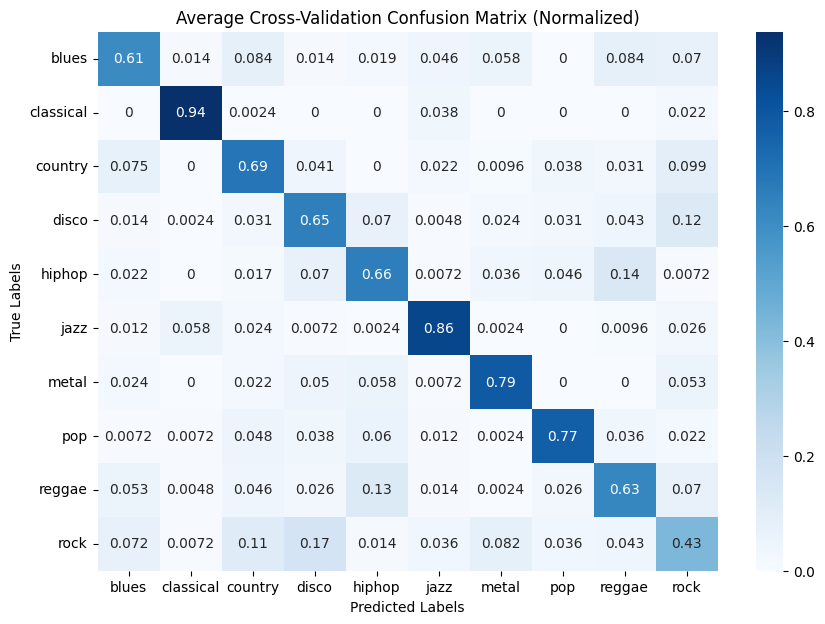

In [ ]:
# Perform manual 5-fold cross-validation on a SVM model with a Radial Basis Function (RBF) kernel
# Note that this manual process was done to ensure that for each fold, all 4 versions of a song remain on the same side of the train-test split.
# This was done by using the base_num as the split index, which also ensured that the testing data for each fold had the same number of songs
# from each genre (meaning that each genre had the same support, ensuring a more inclusive evaluation of the model's performance)

# Initialize the lists that will hold the performance metrics for each fold and initialize the aggregated confusion matrix
num_folds = 5
fold_size = 100 // num_folds
results = []
accuracies = []
aggregated_cm = np.zeros((len(np.unique(df['genre'])), len(np.unique(df['genre']))))

# Loop through each fold, defining the training and testing indices based on the 'base_num' index. Then train a SVM with a RBF kernel and
# extract the model accuracy, precision, recall, and F1-score for each genre, as well as the confusion matrix for that fold.
# Then append metrics to their respective lists
for fold in range(num_folds):
    # Define train and test indices for 'base_num'
    test_start = fold * fold_size
    test_end = test_start + fold_size

    # Split the dataset for the current fold
    train_df = df[~df['base_num'].between(test_start, test_end)]
    test_df = df[df['base_num'].between(test_start, test_end)]

    # Define the training and testing sets (splitting into features and labels)
    X_train = train_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_train = train_df['genre']
    X_test = test_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_test = test_df['genre']

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVM model and make a prediction of the genre
    svm_model = SVC(kernel='rbf', gamma='scale')
    svm_model.fit(X_train_scaled, y_train)
    y_pred = svm_model.predict(X_test_scaled)

    # Computer the accuracy for this fold and append it to the accuracy list
    accuracies.append(accuracy_score(y_test, y_pred))

    # Collect the precision, recall, and F1-score for each genre for this fold and append it to the results list
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(df['genre']))
    results.append((precision, recall, fscore))

    # Compute the confusion matrix for this fold and add it towards the aggregated confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(df['genre']))
    aggregated_cm += cm

# Calculate the average metrics across all 5 folds
avg_precision = np.mean([result[0] for result in results], axis=0)
avg_recall = np.mean([result[1] for result in results], axis=0)
avg_fscore = np.mean([result[2] for result in results], axis=0)
avg_accuracy = np.mean(accuracies)

# Calculate the average confusion matrix across all 5 folds (normalized across each row)
avg_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]

# Extract all 10 genres from the dataframe
labels = np.unique(df['genre'])

# Print average results of the 5-fold cross validation
print('Average classification report:')
for i, label in enumerate(labels):
    print(f'{label}: Precision: {avg_precision[i]}, Recall: {avg_recall[i]}, F1-Score: {avg_fscore[i]}')

print(f'\nAverage Model Accuracy: {avg_accuracy}')

# Plot the average normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(avg_cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Average Cross-Validation Confusion Matrix (Normalized)')
plt.show()


Average classification report:
blues: Precision: 0.6672328325269501, Recall: 0.6341666666666667, F1-Score: 0.649260710093149
classical: Precision: 0.9389846969577655, Recall: 0.9047619047619048, F1-Score: 0.912376415090258
country: Precision: 0.6473376168149263, Recall: 0.7039285714285715, F1-Score: 0.6696898887773689
disco: Precision: 0.5950609526078208, Recall: 0.6183333333333334, F1-Score: 0.6014044702613703
hiphop: Precision: 0.64892349844978, Recall: 0.6161904761904762, F1-Score: 0.6244657851570256
jazz: Precision: 0.786923381191299, Recall: 0.8482142857142858, F1-Score: 0.811033717575637
metal: Precision: 0.7976973279487012, Recall: 0.8172619047619047, F1-Score: 0.803033644475625
pop: Precision: 0.8186766485867809, Recall: 0.7744047619047618, F1-Score: 0.7899953480651234
reggae: Precision: 0.5721279720183052, Recall: 0.6076190476190476, F1-Score: 0.5813303154917673
rock: Precision: 0.4907351448988672, Recall: 0.4102380952380953, F1-Score: 0.4388593269572726

Average Model Accurac

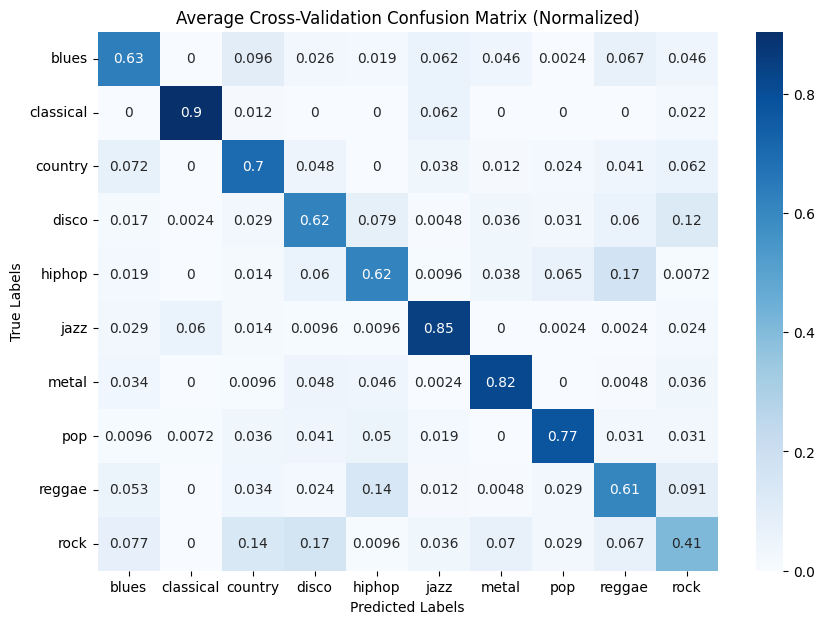

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Perform manual 5-fold cross-validation on a RFC model
# Note that this manual process was done to ensure that for each fold, all 4 versions of a song remain on the same side of the train-test split.
# This was done by using the base_num as the split index, which also ensured that the testing data for each fold had the same number of songs
# from each genre (meaning that each genre had the same support, ensuring a more inclusive evaluation of the model's performance)

# Initialize the lists that will hold the performance metrics and confusion matrix for each fold
num_folds = 5
fold_size = 100 // num_folds
results = []
accuracies = []
aggregated_cm = np.zeros((len(np.unique(df['genre'])), len(np.unique(df['genre']))))

# Loop through each fold, defining the training and testing indices based on the 'base_num' index. Then train a RFC model and
# extract the model accuracy, precision, recall, and F1-score for each genre, as well as the confusion matrix for that fold.
# Then append metrics to their respective lists
for fold in range(num_folds):
    # Define train and test indices for 'base_num'
    test_start = fold * fold_size
    test_end = test_start + fold_size

    # Split the dataset for the current fold
    train_df = df[~df['base_num'].between(test_start, test_end)]
    test_df = df[df['base_num'].between(test_start, test_end)]

    # Define the training and testing sets (splitting into features and labels)
    X_train = train_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_train = train_df['genre']
    X_test = test_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_test = test_df['genre']

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the RFC model and make a prediction of the genre
    rfc_model = RandomForestClassifier(random_state=20)
    rfc_model.fit(X_train_scaled, y_train)
    y_pred = rfc_model.predict(X_test_scaled)

    # Computer the accuracy for this fold and append it to the accuracy list
    accuracies.append(accuracy_score(y_test, y_pred))

    # Collect the precision, recall, and F1-score for each genre for this fold and append it to the results list
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(df['genre']))
    results.append((precision, recall, fscore))

    # Compute the confusion matrix for this fold and add it towards the aggregated confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(df['genre']))
    aggregated_cm += cm

# Calculate the average metrics across all 5 folds
avg_precision = np.mean([result[0] for result in results], axis=0)
avg_recall = np.mean([result[1] for result in results], axis=0)
avg_fscore = np.mean([result[2] for result in results], axis=0)
avg_accuracy = np.mean(accuracies)

# Calculate the average confusion matrix across all 5 folds (normalized across each row)
avg_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]

# Extract all 10 genres from the dataframe
labels = np.unique(df['genre'])

# Print average results of the 5-fold cross validation
print('Average classification report:')
for i, label in enumerate(labels):
    print(f'{label}: Precision: {avg_precision[i]}, Recall: {avg_recall[i]}, F1-Score: {avg_fscore[i]}')

print(f'\nAverage Model Accuracy: {avg_accuracy}')

# Plot the average normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(avg_cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Average Cross-Validation Confusion Matrix (Normalized)')
plt.show()

